# Cats and Dogs (Feature Extraction - VGG16)

In [1]:
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import os
import shutil
from os import listdir
from os.path import isfile, join

TensorFlow 2.x selected.


In [0]:
url = "https://github.com/anthonyng2/ml_python_2019/raw/master/dogs_and_cats.zip"
zip_dir = tf.keras.utils.get_file('dogs_and_cats.zip', origin=url, extract=True)

In [3]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/dogs_and_cats
/root/.keras/datasets/dogs_and_cats/train
/root/.keras/datasets/dogs_and_cats/train/cats
/root/.keras/datasets/dogs_and_cats/train/dogs
/root/.keras/datasets/dogs_and_cats/validation
/root/.keras/datasets/dogs_and_cats/validation/cats
/root/.keras/datasets/dogs_and_cats/validation/dogs


In [0]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'dogs_and_cats')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [6]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 400
total training dog images: 400
total validation cat images: 150
total validation dog images: 150
--
Total training images: 800
Total validation images: 300


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split

rows = 128
cols= 128

# Feature Extraction

In [8]:
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

x_train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,)

train_datagen = x_train_datagen.flow_from_directory(train_dir,
                                                    target_size=(rows,cols),
                                                    batch_size=40,
                                                    class_mode='binary')

Found 800 images belonging to 2 classes.


In [0]:
train_sample_size = train_datagen.samples
train_features = np.zeros(shape=(train_sample_size, 4, 4, 512))    # rows, cols, depth are based on block5_pool dim
train_labels = np.zeros(train_sample_size)
i = 0
for batch_features, batch_labels in train_datagen:
    extracted_features = base_model.predict(batch_features)
    train_features[i * train_datagen.batch_size : (i+1) * train_datagen.batch_size] = extracted_features
    train_labels[i * train_datagen.batch_size : (i+1) * train_datagen.batch_size] = batch_labels
    i += 1
    if i * train_datagen.batch_size >= train_sample_size:
        break

In [11]:
x_val_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = x_val_datagen.flow_from_directory(validation_dir,
                                                target_size=(rows,cols),
                                                batch_size=40,
                                                class_mode='binary')

Found 300 images belonging to 2 classes.


In [0]:
val_sample_size = val_datagen.samples
val_features = np.zeros(shape=(val_sample_size, 4, 4, 512))    # rows, cols, depth are based on block5_pool dim
val_labels = np.zeros(val_sample_size)
i = 0
for batch_features, batch_labels in val_datagen:
    extracted_features = base_model.predict(batch_features)
    val_features[i * val_datagen.batch_size : (i+1) * val_datagen.batch_size] = extracted_features
    val_labels[i * val_datagen.batch_size : (i+1) * val_datagen.batch_size] = batch_labels
    i += 1
    if i * val_datagen.batch_size >= val_sample_size:
        break

In [0]:
train_features = np.reshape(train_features, (train_sample_size, 4 * 4 * 512))
val_features = np.reshape(val_features, (val_sample_size, 4 * 4 * 512))

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(512, activation = 'relu', input_dim = (4 * 4 * 512)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [16]:
epochs = 50

H = model.fit(train_features, train_labels,
                epochs=epochs,
                batch_size = 30,
                validation_data=(val_features,val_labels))

Train on 800 samples, validate on 300 samples
Epoch 1/50
800/800 [==============================] - 1s 2ms/sample - loss: 0.6998 - acc: 0.6200 - val_loss: 0.6837 - val_acc: 0.5867
Epoch 2/50
800/800 [==============================] - 0s 349us/sample - loss: 0.4833 - acc: 0.7663 - val_loss: 0.8012 - val_acc: 0.6233
Epoch 3/50
800/800 [==============================] - 0s 324us/sample - loss: 0.4343 - acc: 0.8012 - val_loss: 0.4166 - val_acc: 0.8167
Epoch 4/50
800/800 [==============================] - 0s 321us/sample - loss: 0.3653 - acc: 0.8438 - val_loss: 0.4100 - val_acc: 0.7800
Epoch 5/50
800/800 [==============================] - 0s 324us/sample - loss: 0.3250 - acc: 0.8575 - val_loss: 0.4275 - val_acc: 0.8133
Epoch 6/50
800/800 [==============================] - 0s 327us/sample - loss: 0.2889 - acc: 0.8788 - val_loss: 0.3995 - val_acc: 0.8300
Epoch 7/50
800/800 [==============================] - 0s 315us/sample - loss: 0.2529 - acc: 0.9025 - val_loss: 0.4471 - val_acc: 0.8167
Epoc

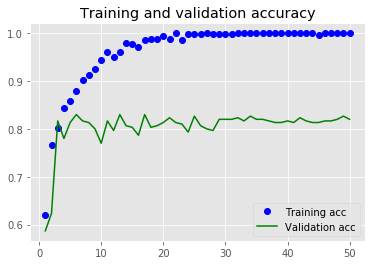

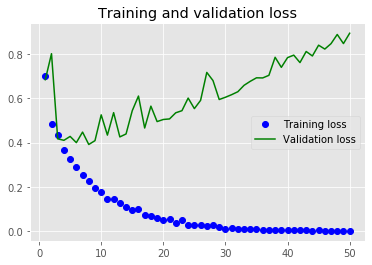

In [17]:
acc = H.history['acc']
val_acc = H.history['val_acc']
loss = H.history['loss']
val_loss = H.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

References:

1. [Anthony Tanbakuchi](http://tanbakuchi.com/posts/comparison-of-openv-interpolation-algorithms/ )







